In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Autoencoder

We have seen how to construct a simple neural network with one hidden layer that can successfully recognise handwritten digits. This network can be considered as an example of an encoder, which takes some high-dimensional input (in this case an image represented by a vector with 784 components) and encodes it into a lower-dimensional representation (a vector of 10 numbers which may be interpreted in terms of probabilities).

In [3]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [4]:
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        training_data = list(training_data)
        n = len(training_data)

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {} : {} / {}".format(j,self.evaluate(test_data),n_test));
            else:
                print("Epoch {} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \\partial C_x /
        \\partial a for the output activations."""
        return (output_activations-y)

In [5]:
import mnist_loader

def plot_digit(digit):
    # A function to plot a vector of length 784 as a 28 x 28 image
    digit_image = digit.reshape(28,28)
    plt.imshow(digit_image, cmap = plt.get_cmap('gray'))
    plt.axis("off")
    plt.show()

## 1.1 Encoder

Construct and train an encoder, a network that takes in a vector of 784 numbers and produces a vector of 10 numbers. Your network should have no hidden layers.

In [6]:
encoder = Network([784, 10])

training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
# Make lists as they are zip and once opne, it changes its state
training_data = list(training_data)
validation_data = list(validation_data)
test_data = list(test_data)

In [7]:
encoder.SGD(training_data, 10, 10, 3.0, test_data=test_data)

Epoch 0 : 7372 / 10000
Epoch 1 : 7427 / 10000
Epoch 2 : 7455 / 10000
Epoch 3 : 7448 / 10000
Epoch 4 : 7456 / 10000
Epoch 5 : 7481 / 10000
Epoch 6 : 7499 / 10000
Epoch 7 : 7487 / 10000
Epoch 8 : 7470 / 10000
Epoch 9 : 7501 / 10000


## 1.2 Decoder

Construct and train a corresponding decoder, a network that does the reverse of this process. The decoder should take a vector of 10 numbers and reconstruct a vector with 784 numbers representing an image of a handwritten digit.

In [8]:
decoder = Network([10, 784])

In [9]:
training_data_inv = []

for x, y in training_data:
  training_data_inv.append((y, x))

In [10]:
decoder.SGD(training_data_inv, 10, 10, 3.0)

Epoch 0 complete
Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete


Since the decoder goes from number 0-9 to image of digit, the weights indicate how important it is for that number that the pixel it is pointing to is filled up for a proper representation of the digit.

Use your decoder to produce a set of 10 images, one for each “perfect” example of a digit. Here, perfect means the input vector only has one non-zero entry and it is equal to 1.

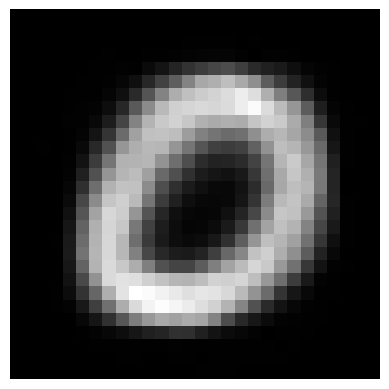

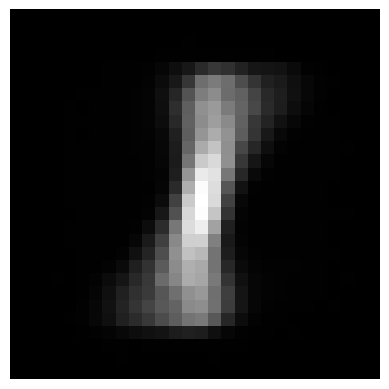

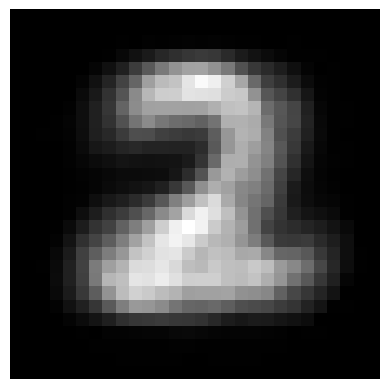

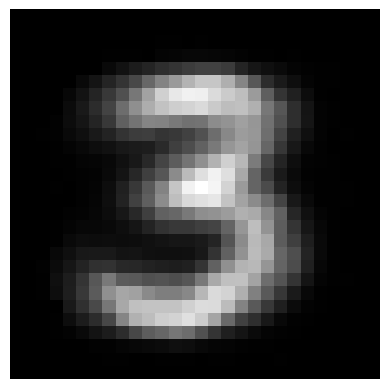

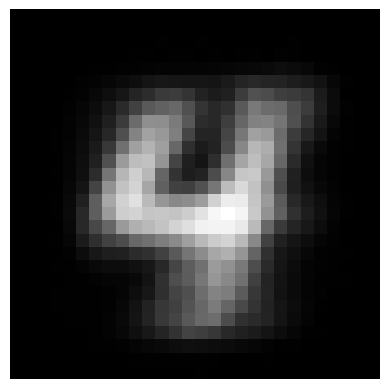

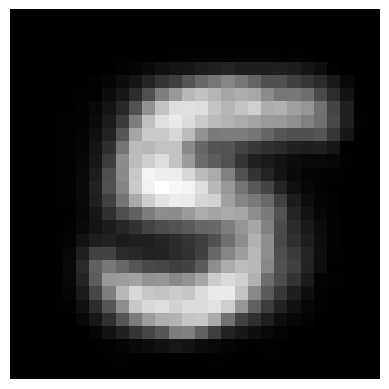

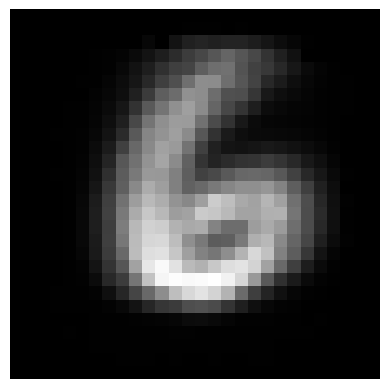

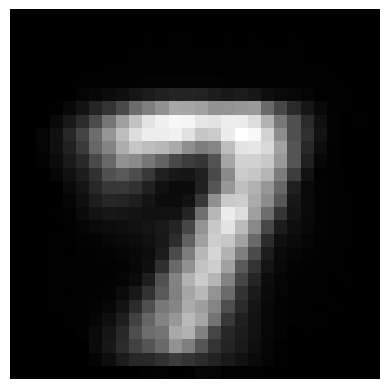

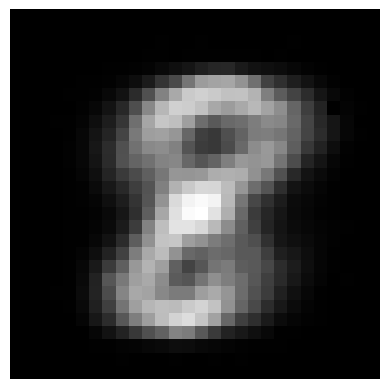

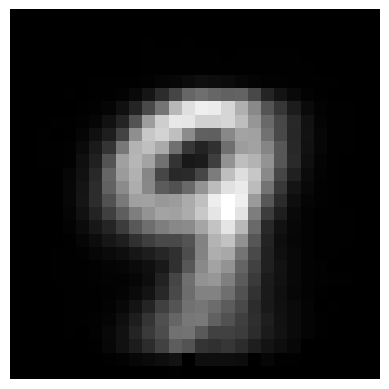

In [11]:
for i in range(10):
  one_hot = np.eye(10)[i].reshape(10, 1) # Reshape one_hot to be a column vector (10, 1)

  image = decoder.feedforward(one_hot)
  plot_digit(image)

## 1.3 Autoencoder

Combine the two networks to produce an autoencoder, which takes an input vector of 784 components and produces an output vector with 784 components.

In [12]:
def autoencoder_feedforward(input):
    encoded = encoder.feedforward(input)
    decoded = decoder.feedforward(encoded)
    return decoded

In [13]:
encoder.feedforward(validation_data[0][0])

array([[4.86612553e-17],
       [3.07362998e-06],
       [3.79766811e-04],
       [3.63171208e-11],
       [7.47148682e-18],
       [2.77684923e-05],
       [3.02344766e-12],
       [1.53359756e-22],
       [5.71255432e-11],
       [1.16257119e-26]])

Test your autoencoder with a sample of 10 digits from the validation set. Include 5 cases where the encoder correctly predicts the expected output and 5 cases where it does not.

In [14]:
validation_data[0][1]

np.int64(3)

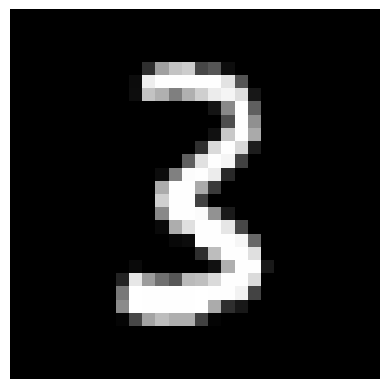

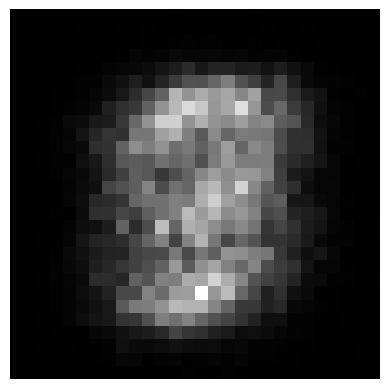

Was: 3, Guessed:2


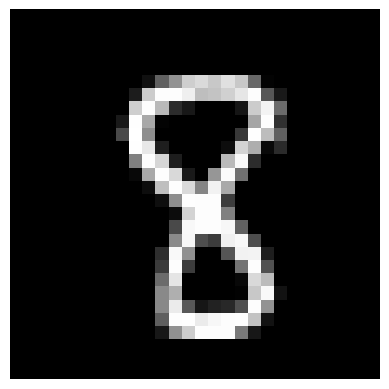

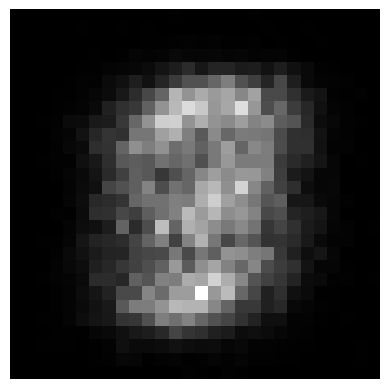

Was: 8, Guessed:5


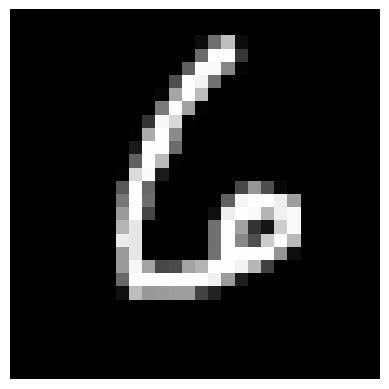

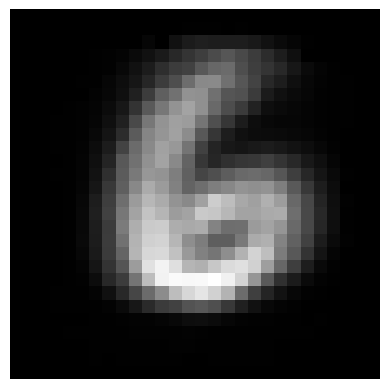

Was: 6, Guessed:6


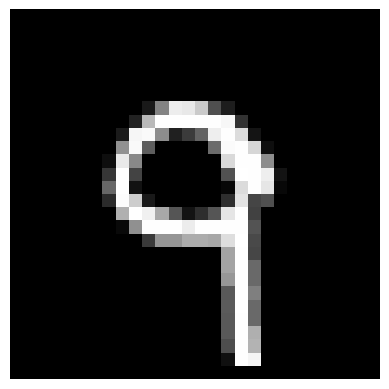

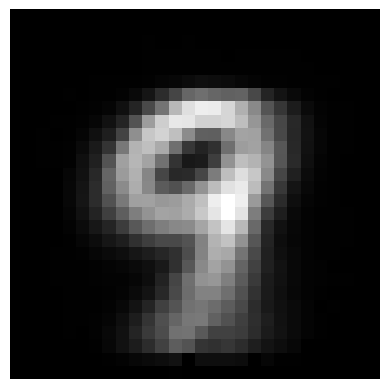

Was: 9, Guessed:9


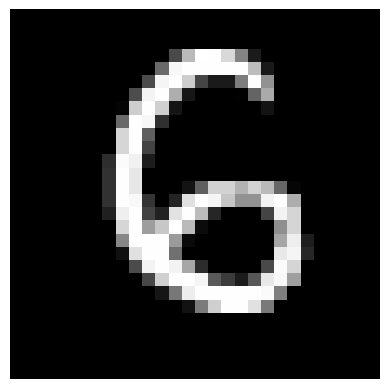

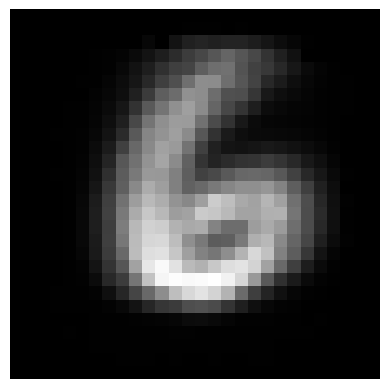

Was: 6, Guessed:6


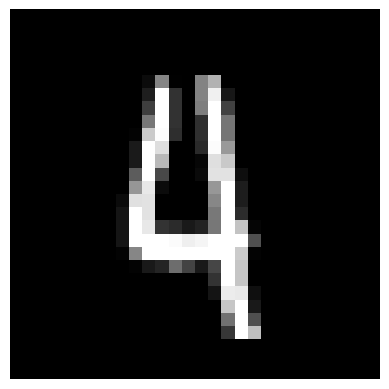

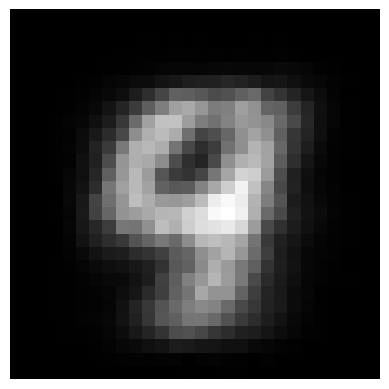

Was: 4, Guessed:4


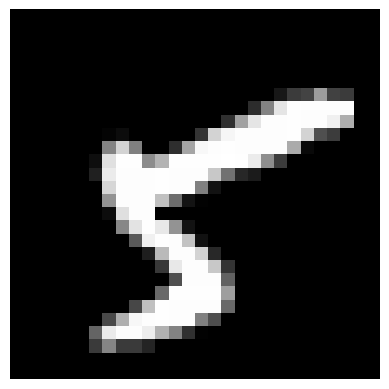

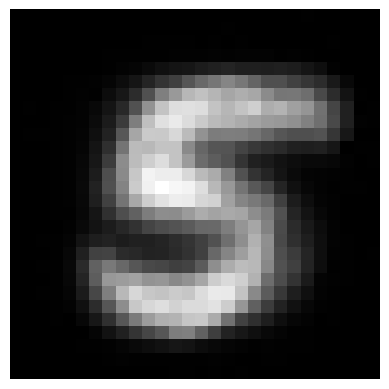

Was: 5, Guessed:5


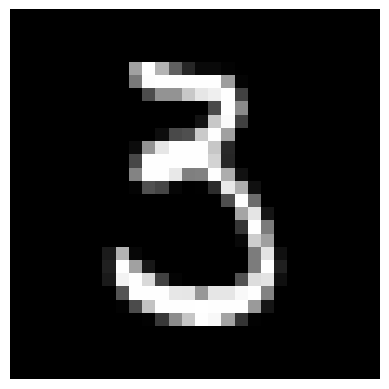

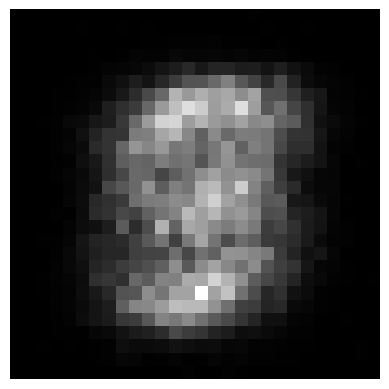

Was: 3, Guessed:5


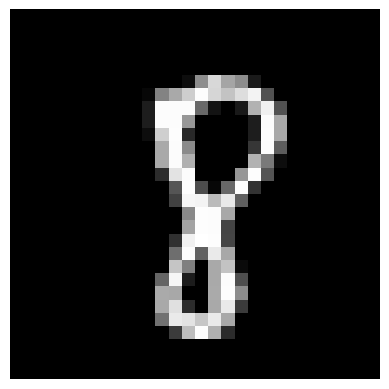

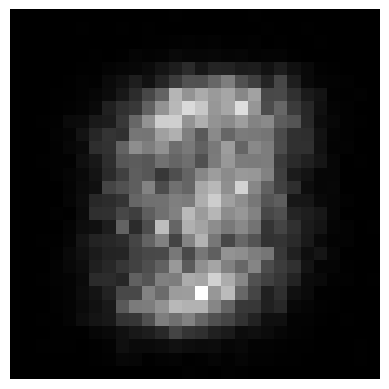

Was: 8, Guessed:5


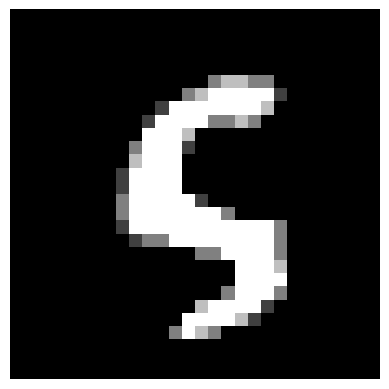

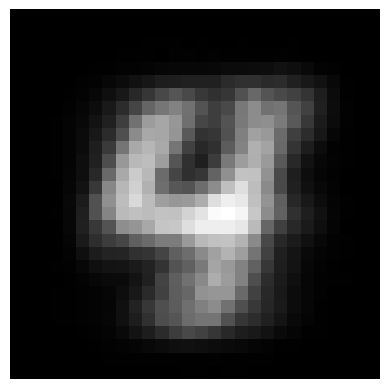

Was: 5, Guessed:4


In [15]:
correct_count, incorrect_count = 0, 0

for x, y in validation_data:
  if np.argmax(encoder.feedforward(x)) == y and correct_count<5:
    correct_count += 1
    plot_digit(x)
    plot_digit(autoencoder_feedforward(x))
    print(f"Was: {y}, Guessed:{np.argmax(encoder.feedforward(x))}")

  elif np.argmax(encoder.feedforward(x)) != y and incorrect_count<5:
    incorrect_count += 1
    plot_digit(x)
    plot_digit(autoencoder_feedforward(x))
    print(f"Was: {y}, Guessed:{np.argmax(encoder.feedforward(x))}")

  #plot_digit(autoencoder_feedforward(x))
  if correct_count + incorrect_count == 10: break

## 1.4 A 40-neuron hidden layer autoencoder

Produce another autoencoder as before, completing the steps above, but include a hidden layer with 40 neurons in both the encoder and decoder.

In [16]:
# a)
encoder = Network([784, 40, 10])
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
# Make lists as they are zip and once opne, it changes its state
training_data = list(training_data)
validation_data = list(validation_data)
test_data = list(test_data)

encoder.SGD(training_data, 10, 10, 0.5, test_data=test_data)

Epoch 0 : 7250 / 10000
Epoch 1 : 8724 / 10000
Epoch 2 : 8973 / 10000
Epoch 3 : 9105 / 10000
Epoch 4 : 9164 / 10000
Epoch 5 : 9236 / 10000
Epoch 6 : 9265 / 10000
Epoch 7 : 9294 / 10000
Epoch 8 : 9326 / 10000
Epoch 9 : 9336 / 10000


In [17]:
# b)
decoder = Network([10, 40, 784])

training_data_inv = []
for x, y in training_data:
  training_data_inv.append((y, x))

decoder.SGD(training_data_inv, 10, 10, 3.0)

Epoch 0 complete
Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete


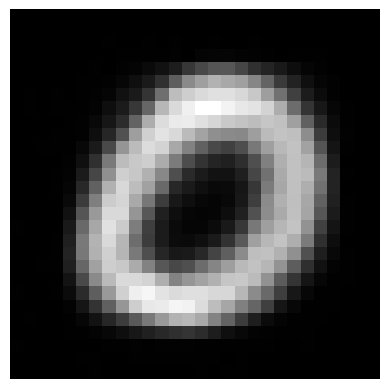

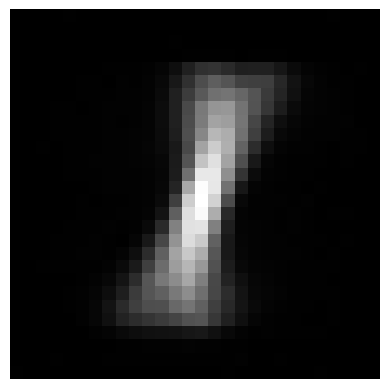

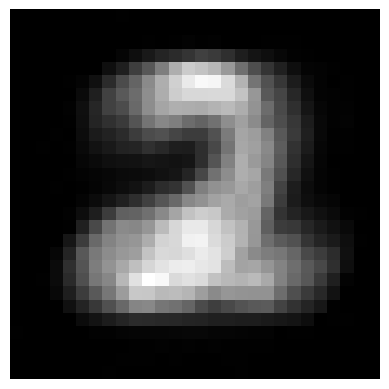

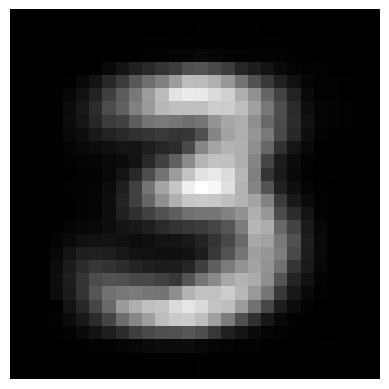

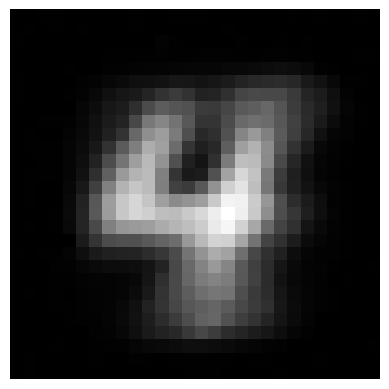

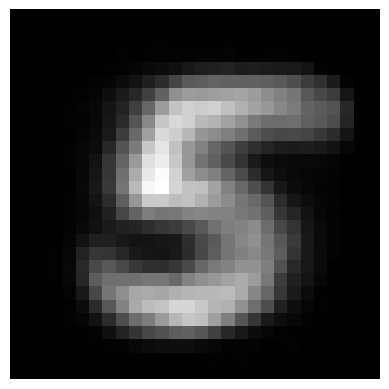

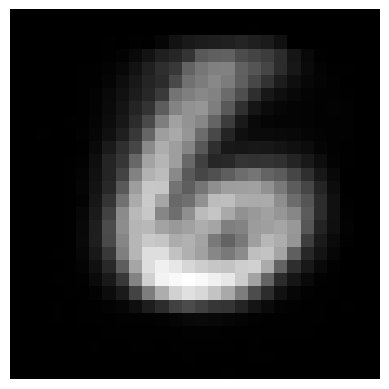

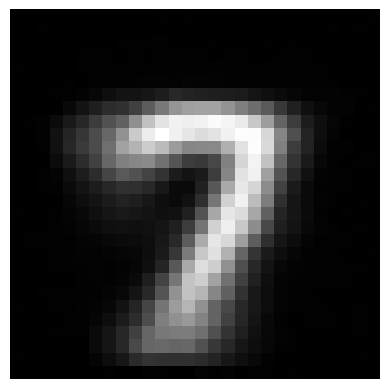

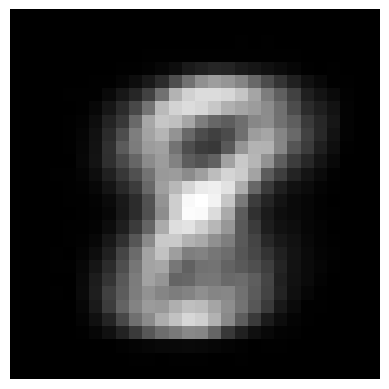

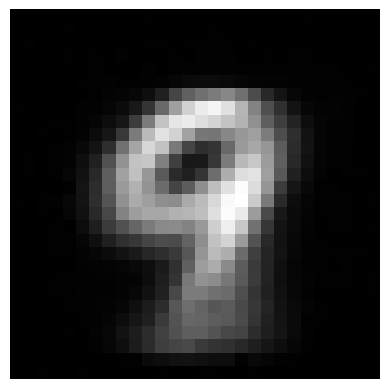

In [18]:
# d)
for i in range(10):
  one_hot = np.eye(10)[i].reshape(10, 1) # Reshape one_hot to be a column vector (10, 1)
  image = decoder.feedforward(one_hot)
  plot_digit(image)

In [19]:
#e)
def autoencoder_feedforward(input):
    encoded = encoder.feedforward(input)
    decoded = decoder.feedforward(encoded)
    return decoded

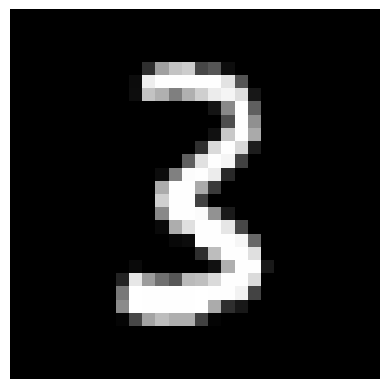

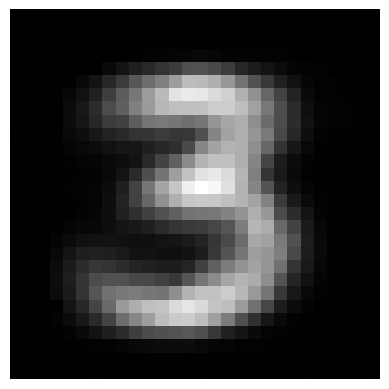

Was: 3, Guessed:3


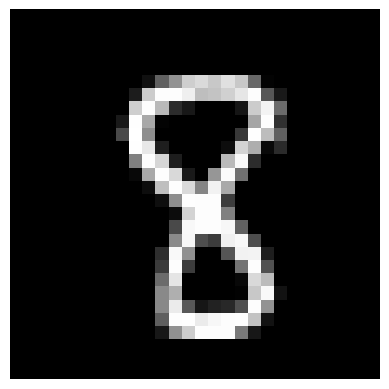

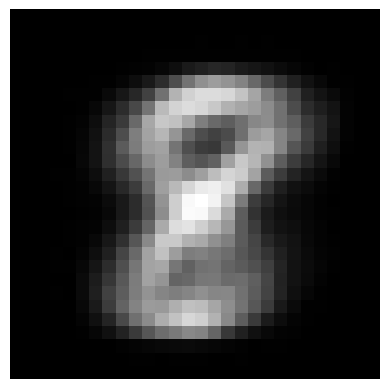

Was: 8, Guessed:8


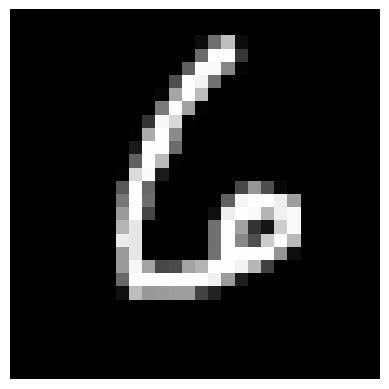

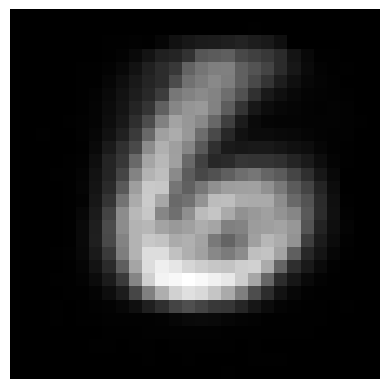

Was: 6, Guessed:6


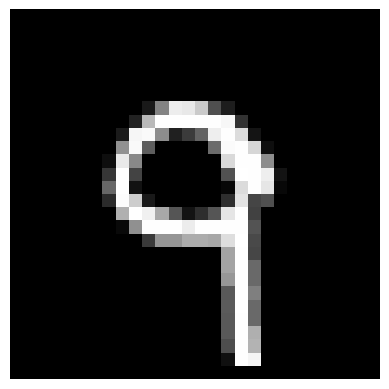

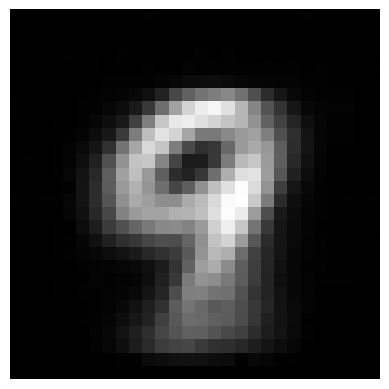

Was: 9, Guessed:9


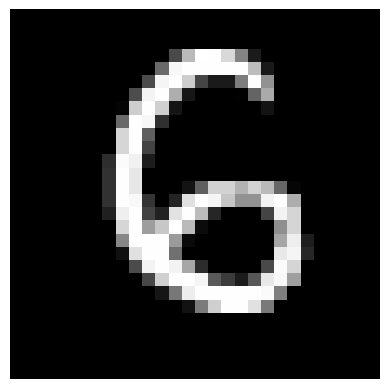

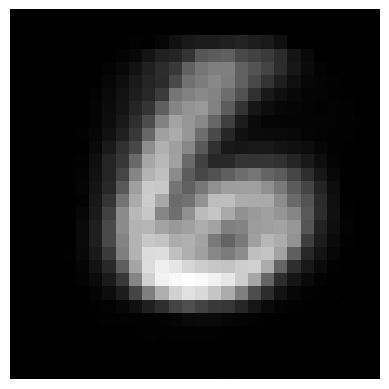

Was: 6, Guessed:6


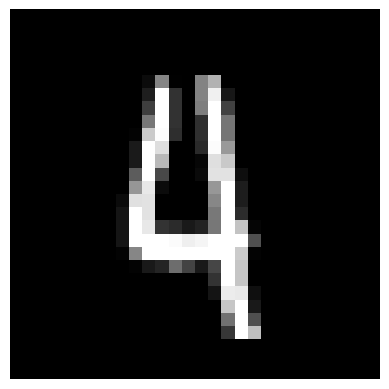

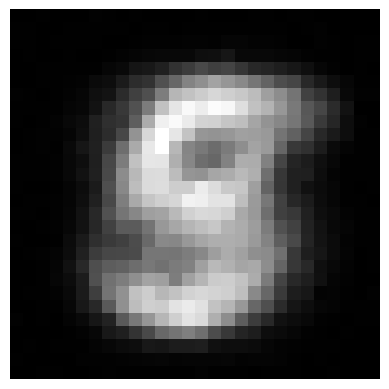

Was: 4, Guessed:2


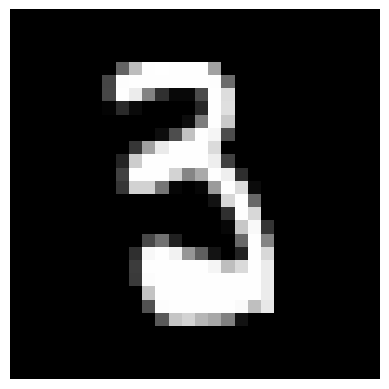

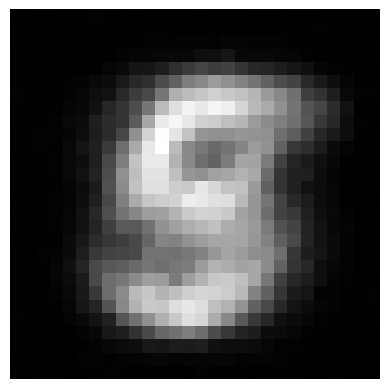

Was: 3, Guessed:6


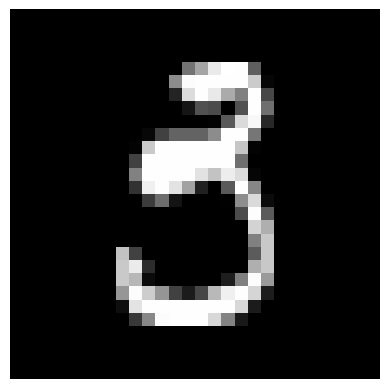

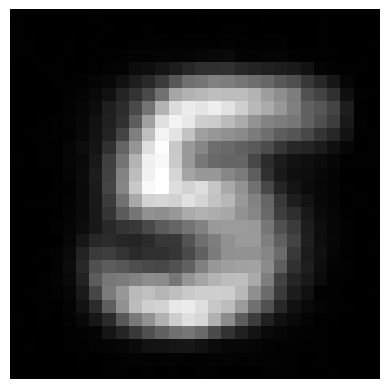

Was: 3, Guessed:5


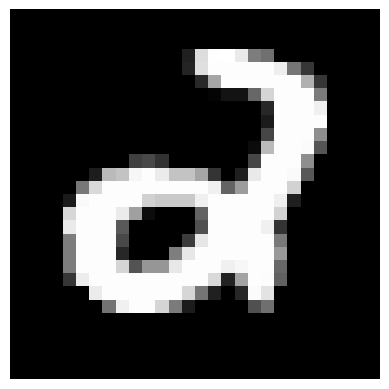

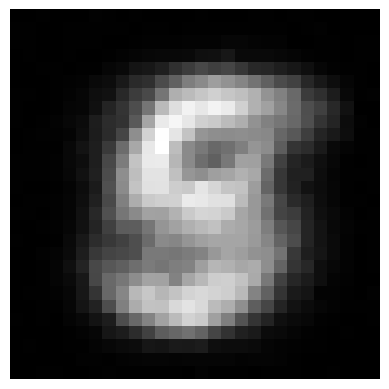

Was: 2, Guessed:6


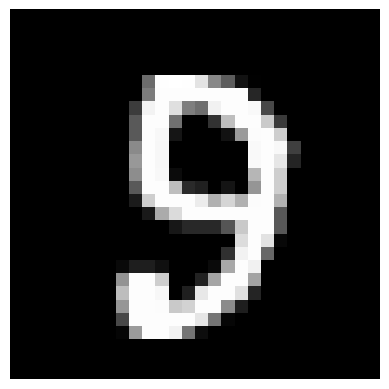

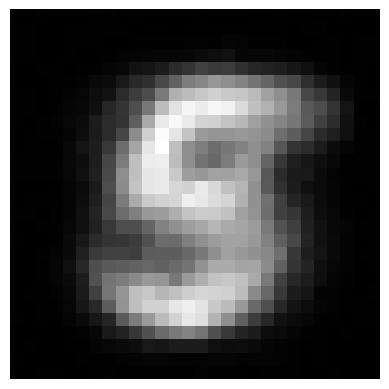

Was: 9, Guessed:5


In [20]:
#f)
correct_count, incorrect_count = 0, 0

for x, y in validation_data:
  if np.argmax(encoder.feedforward(x)) == y and correct_count<5:
    correct_count += 1
    plot_digit(x)
    plot_digit(autoencoder_feedforward(x))
    print(f"Was: {y}, Guessed:{np.argmax(encoder.feedforward(x))}")

  elif np.argmax(encoder.feedforward(x)) != y and incorrect_count<5:
    incorrect_count += 1
    plot_digit(x)
    plot_digit(autoencoder_feedforward(x))
    print(f"Was: {y}, Guessed:{np.argmax(encoder.feedforward(x))}")

  #plot_digit(autoencoder_feedforward(x))
  if correct_count + incorrect_count == 10: break

# 2. Training a neural network with TensorFlow and Keras

You wish to produce neural networks that approximate the functions
$$f(x) = sin\, x \\ g(x) = (1+sin\, x)/2$$

## 2.1 Training data

Create training data by evaluating $f(x)$ and $g(x)$ at 10,000 equally-spaced points in the range $x ∈[0,2π]$.

In [ ]:
x = np.linspace(0, 2*np.pi, 10000)
fx = np.sin(x)
gx = (1 + np.sin(x)) / 2

## 2.2 Architecture

Using TensorFlow and Keras, construct neural networks for the two functions with the following properties:

• An input layer with a single neuron.

• A hidden layer with 3 neurons and a logistic sigmoid activation function.

• An output layer with a single neuron and a logistic sigmoid activation function.

In [ ]:
fmodel = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(1,)),
  tf.keras.layers.Dense(3, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

gmodel = tf.keras.models.clone_model(fmodel)

## 2.3 Training

Train your networks using the training data you produced. Use the following parameters for training:

• A mean squared error cost function.

• Batch size 20.

• 200 epochs.

In [ ]:
fmodel.compile(optimizer='adam',
              loss="mean_squared_error")

fmodel.fit(x, fx, epochs=200, batch_size=20)

Epoch 1/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5369
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4748
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4550
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4214
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3971
Epoch 6/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3630
Epoch 7/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3387
Epoch 8/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3376
Epoch 9/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3213
Epoch 10/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3179
Epoch 11/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3138
Epoch 12/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3114
Epoch 13/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3048
Epoch 14/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2979
Epoch 15/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
gmodel.compile(optimizer='adam',
              loss="mean_squared_error")

gmodel.fit(x, gx, epochs=200, batch_size=20)

Epoch 1/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1527
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0843
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0603
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0461
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0378
Epoch 6/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0322
Epoch 7/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0285
Epoch 8/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0266
Epoch 9/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0253
Epoch 10/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0249
Epoch 11/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0232
Epoch 12/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0227
Epoch 13/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0216
Epoch 14/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0213
Epoch 15/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
fmodel.save("/content/drive/MyDrive/4th year/MoML/fmodel.keras")
gmodel.save("/content/drive/MyDrive/4th year/MoML/gmodel.keras")


## 2.4 Comparison

Produce a plot comparing your models against the true functions $f (x)$ and $g(x)$ over the range $x ∈[0,2π]$. Comment on if one model performs better than the other, and why.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


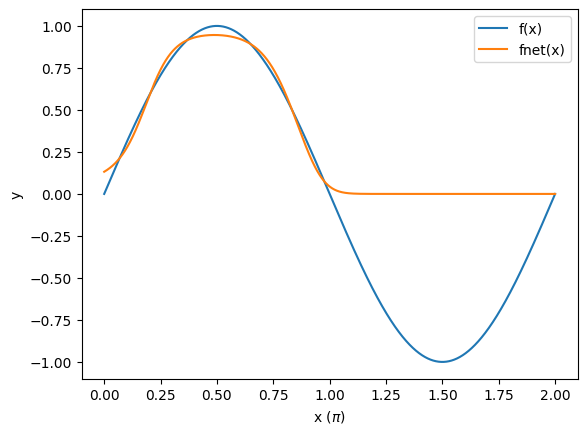

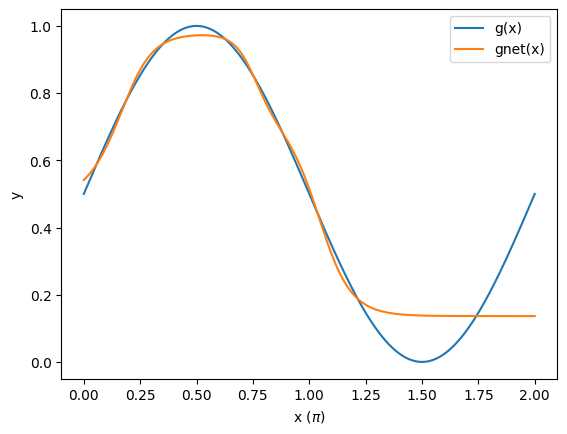

In [ ]:
fnet = fmodel.predict(x)
gnet = gmodel.predict(x)

plt.plot(x/np.pi, fx, label ='f(x)')
plt.plot(x/np.pi, fnet, label='fnet(x)')
plt.xlabel('x ($\\pi$)')
plt.ylabel('y')
plt.legend()
plt.show()

plt.plot(x/np.pi, gx, label ='g(x)')
plt.plot(x/np.pi, gnet, label='gnet(x)')
plt.xlabel('x ($\\pi$)')
plt.ylabel('y')
plt.legend()
plt.show()

Both models seem similarly accurate up until $\pi$ but after that, `gnet(x)` is clearly more accurate as `sigmoid` cannot return negative values making `fnet(x)`0 after that. This could be solved like this:

Epoch 1/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5276
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4076
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3137
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2424
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1842
Epoch 6/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1483
Epoch 7/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1270
Epoch 8/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1132
Epoch 9/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1010
Epoch 10/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0925
Epoch 11/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0836
Epoch 12/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0716
Epoch 13/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0599
Epoch 14/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0514
Epoch 15/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 1

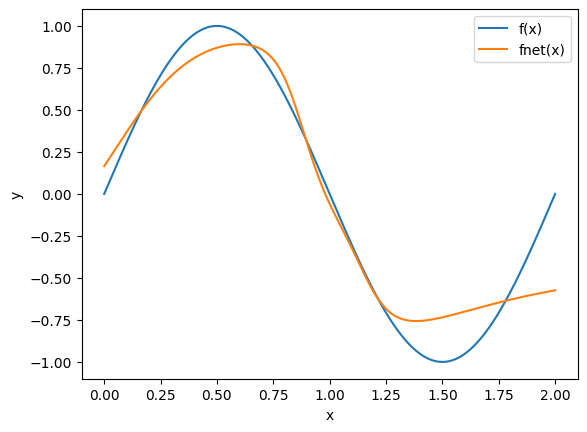

In [ ]:
def shifted_sigmoid(x):
    return 2 * 1.0/(1.0+tf.exp(-x)) - 1

# Model
fmodel_ = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(1,)),
  tf.keras.layers.Dense(3, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation=shifted_sigmoid)
])

# Train
fmodel_.compile(optimizer='adam',
              loss="mean_squared_error")
fmodel_.fit(x, fx, epochs=200, batch_size=20)

# Predict
fnet = fmodel_.predict(x)
plt.plot(x/np.pi, fx, label ='f(x)')
plt.plot(x/np.pi, fnet, label='fnet(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Notice how the shape of the output is essentially the same as for `gnet(x)` since they are esentially the same function just shifted. Small changes might happen due to the retrainning of the network.

## 2.5 Evaluation on un-seen data

Plot your model for $g(x)$ over the range $x ∈[0,4π]$. Comment on and give an explanation for the performance of your model in this case. Your comment should include two possible explanations based on (i) the training data used and (ii) the expressivity of a network with three hidden neurons.

 78/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-864983077.py:6: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('x ($\pi$)')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


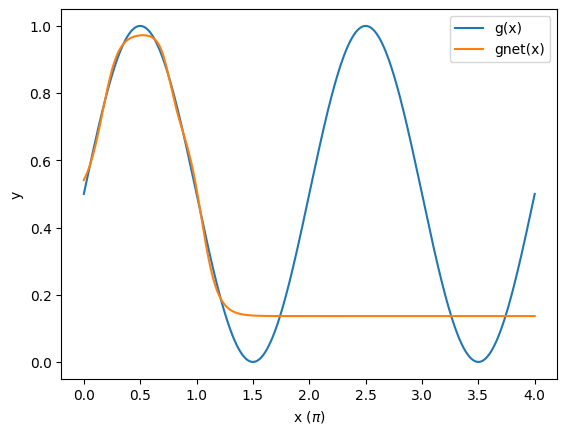

In [ ]:
gx2 = (1 + np.sin(2*x)) / 2

plt.plot(2*x/np.pi, gx2, label ='g(x)')
plt.plot(2*x/np.pi, gmodel.predict(2*x), label='gnet(x)')

plt.xlabel('x ($\pi$)')
plt.ylabel('y')
plt.legend()
plt.show()

The model essentially fails at the same time as before diverging from the solution as it does not know that it is periodical with a period of $2\pi$. This could be saved with (i) larger data covering at least 2 periods and/or (ii) more neurons in the hidden layer, 3 neurons implies only 3 'bumps' to model the function.